In [1]:
from pathlib import Path
from shutil import copyfile
import pickle

Data manipulation

In [2]:
import numpy as np
import pandas as pd

Plotting / Visualisation

In [3]:
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 6)

Gaussian Process Regression

In [5]:
import gpflow
import tensorflow as tf

In [6]:
from gpflow.utilities import print_summary

In [7]:
gpflow.config.set_default_summary_fmt("notebook")

MATLAB engine

In [8]:
import matlab.engine

In [9]:
eng = matlab.engine.start_matlab()

In [10]:
eng.load_system("../Simulink/polydome", background = True)

## Load weather data

Sample time (in seconds) of the resulting Gaussian Process

In [11]:
Tsample = 15*60

Which experimental set to simulate:

In [12]:
exp_id = 'Exp2'

Copy the corresponding WDB to the model input location:

In [13]:
copyfile(f"../Data/Experimental_data_WDB/{exp_id}_WDB.mat", "../Data/input_WDB.mat")

'../Data/input_WDB.mat'

In [14]:
df_wdb = pd.read_pickle(f"../Data/Experimental_python/{exp_id}_WDB.pkl")
df_wdb.head()

,time,timestamp,zenith,azimuth,dni,dhi,OutsideTemp,Tsky_rad,relative_humidity,precipitation,cloud_index,pressure,wind_speed,wind_direction,aoi,incidence_main,incidence_second,poa_direct,poa_diffuse
0,0,201706101600,37.637775,244.184376,778.389320,153.014998,24.0,18.0,50,-9999,0.5,96300,0,-9999,37.637775,-9999,-9999,616.396540,153.014998
1,300,201706101605,38.415872,245.558388,779.663530,151.020217,24.0,18.0,50,-9999,0.5,96300,0,-9999,38.415872,-9999,-9999,610.883028,151.020217
2,600,201706101610,39.202383,246.896456,776.559233,150.272165,24.0,18.0,50,-9999,0.5,96300,0,-9999,39.202383,-9999,-9999,601.769888,150.272165
3,900,201706101615,39.996665,248.200516,767.177588,151.349615,24.0,18.0,50,-9999,0.5,96300,0,-9999,39.996665,-9999,-9999,587.720827,151.349615
4,1200,201706101620,40.798119,249.472420,762.559533,150.949974,24.0,18.0,50,-9999,0.5,96300,0,-9999,40.798119,-9999,-9999,577.270157,150.949974


In [15]:
df = pd.read_pickle(f"../Data/Experimental_python/{exp_id}_data.pkl")
# Resample the experimental measurements
df = df.resample(f"{Tsample}s").mean()
df['time_h'] = df.index.hour
df['time_m'] = df.index.minute

df.loc[:,'time'] = [0] + (df.index[1:] - df.index[:-1]).seconds.to_list()
df.loc[:, 'time'] = df.loc[:, 'time'].cumsum()

df.head()

,Power,Setpoint,OutsideTemp,SupplyTemp,InsideTemp,SolRad,time_h,time_m,time
timestamp,,,,,,,,,
2017-06-10 16:00:00+02:00,5039.718391,20.500000,24.0,13.2,22.727778,761.015733,16,0,0
2017-06-10 16:15:00+02:00,4563.979693,21.166667,24.0,13.4,22.650000,729.086933,16,15,900
2017-06-10 16:30:00+02:00,4560.348659,21.500000,24.0,13.4,22.622222,699.066333,16,30,1800
2017-06-10 16:45:00+02:00,4535.043678,21.500000,24.0,13.4,22.622222,664.059456,16,45,2700
2017-06-10 17:00:00+02:00,4565.321839,21.500000,24.0,13.4,22.483333,630.548933,17,0,3600


In [16]:
def load_weather_data(exp_id):
    copyfile(f"../Data/Experimental_data_WDB/{exp_id}_WDB.mat", "../Data/input_WDB.mat")
    df_wdb = pd.read_pickle(f"../Data/Experimental_python/{exp_id}_WDB.pkl")
    
    df = pd.read_pickle(f"../Data/Experimental_python/{exp_id}_data.pkl")
    # Resample the experimental measurements
    df = df.resample(f"{Tsample}s").mean()
    
    df['time_h'] = df.index.hour
    df['time_m'] = df.index.minute
    
    df.loc[:,'time'] = [0] + (df.index[1:] - df.index[:-1]).seconds.to_list()
    df.loc[:, 'time'] = df.loc[:, 'time'].cumsum()

    return df_wdb, df

In [17]:
runtime = df_wdb['time'].iloc[-1]
print(f"Experiment runtime: {runtime}")

Experiment runtime: 136500


## Simulink

Set the CARNOT simulation initial temperature `t0`

In [18]:
eng.workspace['t0'] = float(23)

Set the CARNOT simulation air exchange rate

In [19]:
np_air = np.zeros([df_wdb.shape[0], 2])
np_air[:, 0] = df_wdb['time']
np_air[:, 1] = 2.75

In [20]:
eng.workspace['air_exchange_rate'] = matlab.double(np_air.tolist())

### Generate Heat Random Input Signal

In [21]:
Pel_max = 6300
COP_heating = 5.0
COP_cooling = 5.0

Define a function for generating random signals:

In [22]:
def get_random_signal(nstep, a_range = (-1, 1), b_range = (2, 10), signal_type = 'analog'):

    a = np.random.rand(nstep) * (a_range[1]-a_range[0]) + a_range[0] # range for amplitude
    b = np.random.rand(nstep) *(b_range[1]-b_range[0]) + b_range[0] # range for frequency
    b = np.round(b)
    b = b.astype(int)

    b[0] = 0

    for i in range(1,np.size(b)):
        b[i] = b[i-1]+b[i]
        
    if signal_type == 'analog':
        random_signal = np.zeros(nstep)
        # Random Signal
        i=0
        random_signal = np.zeros(nstep)
        while b[i]<np.size(random_signal):
            k = b[i]
            random_signal[k:] = a[i]
            i=i+1
        return random_signal
    elif signal_type == 'prbs':
        
        # PRBS
        a = np.zeros(nstep)
        j = 0
        while j < nstep:
            a[j] = a_range[1]
            a[j+1] = a_range[0]
            j = j+2

        i=0
        prbs = np.zeros(nstep)
        while b[i]<np.size(prbs):
            k = b[i]
            prbs[k:] = a[i]
            i=i+1
            
        return prbs
    else:
        raise ValueError(signal_type)

In [23]:
len_signal = len(df)

random_signal = get_random_signal(len_signal, a_range = (- COP_cooling * Pel_max, COP_heating * Pel_max), signal_type = 'analog')
prbs = get_random_signal(len_signal, a_range = (0, 5), signal_type = 'prbs')

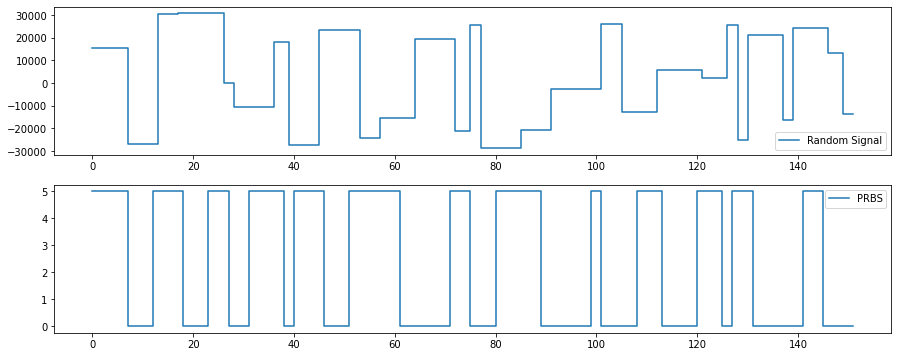

In [24]:
plt.figure() 
plt.subplot(2,1,1)
plt.plot(random_signal, drawstyle='steps',label='Random Signal')
plt.legend()
plt.subplot(2,1,2)
plt.plot(prbs, drawstyle='steps', label='PRBS')
plt.legend()
plt.show()

In [25]:
power = np.array([df['time'], random_signal]).T

In [26]:
eng.workspace['power'] = matlab.double(power.tolist())

### Set the simulation parameters and run it

In [27]:
eng.set_param('polydome', 'StopTime', str(runtime), nargout = 0)

In [28]:
eng.workspace['result'] = eng.sim('polydome')

### Interpret the simulation results

In [29]:
def carnot_to_series(eng, start_timestamp):

    # Compile the simulation dict
    dict_simulation = {}
    dict_simulation['SimulatedTemp'] = np.asarray(eng.eval('result.SimulatedTemp.Data')).reshape(-1)
    dict_simulation['time'] = np.asarray(eng.eval('result.SimulatedTemp.Time')).reshape(-1)
    
    # Create the dataframe from dict
    df_simulation = pd.DataFrame(dict_simulation)
    df_simulation.set_index('time', inplace = True, drop = True)
    
    # Define the timestamps and set it as index
    df_simulation['timestamp'] = start_timestamp + df_simulation.index.map(lambda x: pd.Timedelta(seconds = x))
    df_simulation = df_simulation.reset_index().set_index('timestamp')
    
    # Resample the dataframe to 5 min intervals
    # Taking the mean when there are multiple points, padding with zero order when data is missing
    df_simulation = df_simulation['SimulatedTemp'].resample(f'{Tsample}s').mean().pad()
    
    return df_simulation

In [30]:
df_simulation = carnot_to_series(eng, df.index[0])

In [31]:
df.loc[:,'SimulatedTemp'] = df_simulation
df.loc[:,'SimulatedHeat'] = power[:, 1]

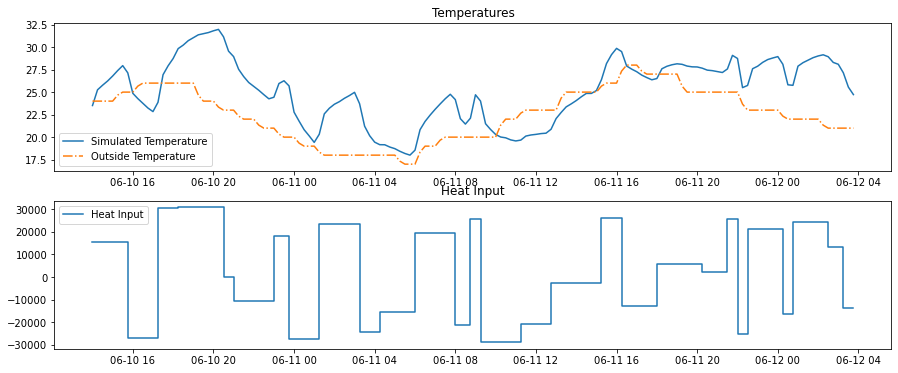

In [32]:
plt.figure() 
plt.subplot(2,1,1)
plt.plot(df['SimulatedTemp'], label = 'Simulated Temperature')
plt.plot(df['OutsideTemp'], '-.', label = 'Outside Temperature')
plt.title('Temperatures')
plt.legend()
plt.subplot(2,1,2)
plt.plot(df['SimulatedHeat'], drawstyle = 'steps', label = 'Heat Input')
plt.title('Heat Input')
plt.legend()
plt.show()

Export the resampled data-set for further use

In [33]:
df_simulation.to_pickle(f"../Data/CARNOT_output/{exp_id}_prbs_simulation_df.pkl")

In [34]:
def simulate_carnot(df_wdb, df, power_signal):
    
    try:
        power = np.array([df['time'], power_signal]).T
    except:
        import pdb; pdb.set_trace()
        pass
    runtime = df_wdb['time'].iloc[-1]
    
    eng.workspace['power'] = matlab.double(power.tolist())
    eng.set_param('polydome', 'StopTime', str(runtime), nargout = 0)
    eng.workspace['result'] = eng.sim('polydome')
    df_simulation = carnot_to_series(eng, df.index[0])
    
    return df_simulation

In [35]:
train_exps = ['Exp1', 'Exp3', 'Exp5', 'Exp6']
test_exps = ['Exp2', 'Exp4', 'Exp7']

In [36]:
t_cols = ['time_h', 'time_m']
w_cols = ['SolRad', 'OutsideTemp']
u_cols = ['SimulatedHeat']
y_cols = ['SimulatedTemp']

In [37]:
t_lags = 3
w_lags = 1
u_lags = 1
y_lags = 3

In [38]:
dict_cols = {
    't': (t_lags, t_cols),
    'w': (w_lags, w_cols),
    'u': (u_lags, u_cols),
    'y': (y_lags, y_cols)
}

In [39]:
dfs_train = []
dfs_test = []

for exp in train_exps:
    df_wdb, df = load_weather_data(exp)

    len_signal = len(df)
    rnd_power = get_random_signal(
        len_signal,
        a_range = (- COP_cooling * Pel_max, COP_heating * Pel_max),
        signal_type = 'analog'
    )

    df_sim = simulate_carnot(df_wdb, df, rnd_power)
    df.loc[:, 'SimulatedHeat'] = rnd_power
    df.loc[:, 'SimulatedTemp'] = df_sim
    
    dfs_train.append(df)

for exp in test_exps:
    df_wdb, df = load_weather_data(exp)

    len_signal = len(df)
    rnd_power = get_random_signal(
        len_signal,
        a_range = (- COP_cooling * Pel_max, COP_heating * Pel_max),
        signal_type = 'analog'
    )

    df_sim = simulate_carnot(df_wdb, df, rnd_power)
    df.loc[:, 'SimulatedHeat'] = rnd_power
    df.loc[:, 'SimulatedTemp'] = df_sim
    
    dfs_test.append(df)

In [40]:
pickle.dump(dict_cols, open(Path("dict_cols.pkl"), 'wb'))
pickle.dump(dfs_train, open(Path("dfs_train.pkl"), 'wb'))
pickle.dump(dfs_test, open(Path("dfs_test.pkl"), 'wb'))

<AxesSubplot:xlabel='timestamp'>

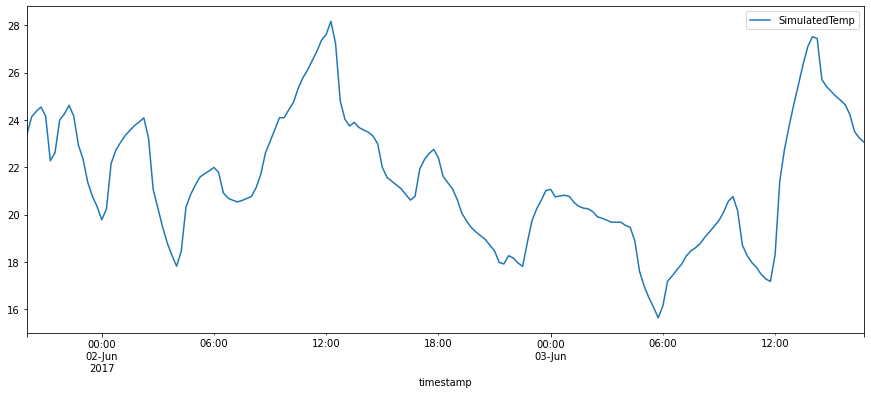

In [41]:
dfs_train[0][['SimulatedTemp']].plot()

### Trim and scale the input data

In [42]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.exceptions import NotFittedError

In [43]:
scaler = MinMaxScaler(feature_range = (-1, 1))
#scaler = RobustScaler()

In [44]:
def get_scaled_df(df, dict_cols, scaler):
    
    t_list = dict_cols['t'][1]
    w_list = dict_cols['w'][1]
    u_list = dict_cols['u'][1]
    y_list = dict_cols['y'][1]
    
    df_local = df[t_list + w_list + u_list + y_list]
    df_scaled = df_local.to_numpy()
    
    try:
        df_scaled = scaler.transform(df_scaled)
    except NotFittedError:
        df_scaled = scaler.fit_transform(df_scaled)
        
    df_scaled = pd.DataFrame(df_scaled, index = df_local.index, columns = df_local.columns)
    
    return df_scaled

In [45]:
df_train = pd.concat(dfs_train)

In [46]:
np.linalg.cond(df_train.to_numpy())

279119.2189692174

In [47]:
df_train_sc = get_scaled_df(df_train, dict_cols, scaler)

In [48]:
np.linalg.cond(df_train_sc.to_numpy())

4.58816888677789

In [49]:
dfs_train_sc = []
dfs_test_sc = []
for df in dfs_train:
    df_sc = get_scaled_df(df, dict_cols, scaler)
    dfs_train_sc.append(df_sc)
    
for df in dfs_test:
    df_sc = get_scaled_df(df, dict_cols, scaler)
    dfs_test_sc.append(df_sc)

/usr/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([[<AxesSubplot:title={'center':'time_h'}>,
        <AxesSubplot:title={'center':'time_m'}>],
       [<AxesSubplot:title={'center':'SolRad'}>,
        <AxesSubplot:title={'center':'OutsideTemp'}>],
       [<AxesSubplot:title={'center':'SimulatedHeat'}>,
        <AxesSubplot:title={'center':'SimulatedTemp'}>]], dtype=object)

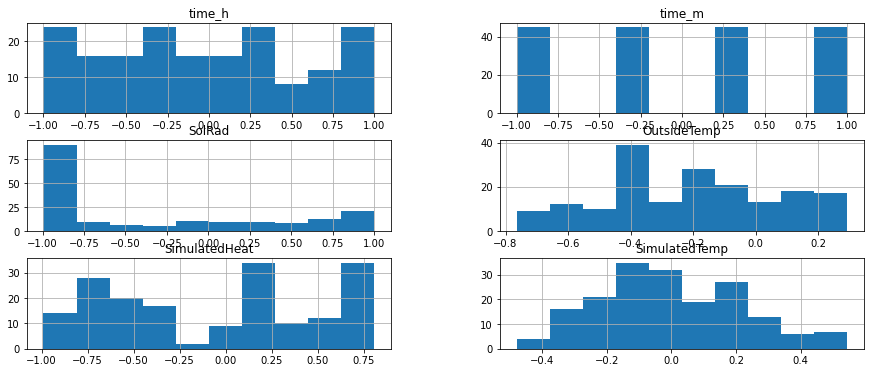

In [50]:
dfs_train_sc[0].hist()

## Gaussian Process Regression

### Compile training set

In [51]:
def data_to_gpr(df, dict_cols):
    
    t_list = dict_cols['t'][1]
    w_list = dict_cols['w'][1]
    u_list = dict_cols['u'][1]
    y_list = dict_cols['y'][1]
    
    df_gpr = df[t_list + w_list + u_list + y_list].copy()
    
    for lags, names in dict_cols.values():
        for name in names:
            col_idx = df_gpr.columns.get_loc(name)
            for lag in range(1, lags + 1):
                df_gpr.insert(col_idx + lag, f"{name}_{lag}", df_gpr.loc[:, name].shift(lag))

    df_gpr.dropna(inplace = True)
    
    return df_gpr

In [52]:
dfs_gpr_train = []
for df_sc in dfs_train_sc:
    dfs_gpr_train.append(data_to_gpr(df_sc, dict_cols))
df_gpr_train = pd.concat(dfs_gpr_train)
df_gpr_train.head()

,time_h,time_h_1,time_h_2,time_h_3,time_m,time_m_1,time_m_2,time_m_3,SolRad,SolRad_1,OutsideTemp,OutsideTemp_1,SimulatedHeat,SimulatedHeat_1,SimulatedTemp,SimulatedTemp_1,SimulatedTemp_2,SimulatedTemp_3
timestamp,,,,,,,,,,,,,,,,,,
2017-06-01 20:45:00+02:00,0.739130,0.739130,0.739130,0.739130,1.000000,0.333333,-0.333333,-1.000000,-0.970807,-0.925970,0.058824,0.058824,0.438090,0.438090,0.248081,0.233535,0.214339,0.153839
2017-06-01 21:00:00+02:00,0.826087,0.739130,0.739130,0.739130,-1.000000,1.000000,0.333333,-0.333333,-0.980063,-0.970807,0.019608,0.058824,0.438090,0.438090,0.216876,0.248081,0.233535,0.214339
2017-06-01 21:15:00+02:00,0.826087,0.826087,0.739130,0.739130,-0.333333,-1.000000,1.000000,0.333333,-0.989906,-0.980063,-0.058824,0.019608,-0.470064,0.438090,0.062767,0.216876,0.248081,0.233535
2017-06-01 21:30:00+02:00,0.826087,0.826087,0.826087,0.739130,0.333333,-0.333333,-1.000000,1.000000,-0.991909,-0.989906,-0.058824,-0.058824,-0.470064,-0.470064,0.091034,0.062767,0.216876,0.248081
2017-06-01 21:45:00+02:00,0.826087,0.826087,0.826087,0.826087,1.000000,0.333333,-0.333333,-1.000000,-0.992483,-0.991909,-0.058824,-0.058824,0.577419,-0.470064,0.203306,0.091034,0.062767,0.216876


In [53]:
np.linalg.cond(
    df_gpr_train.to_numpy()
)

1696122339350262.8

In [54]:
def get_timestamps(start_timestamp, time_delta, n_steps):

    # Define the timestamps and set it as index
    timestamps = np.linspace(0, (n_steps-1)*time_delta, n_steps)
    timestamps = start_timestamp + pd.Series(timestamps).map(lambda x: pd.Timedelta(seconds = x))
    
    return timestamps

In [55]:
df_gpr_train.to_pickle("df_gpr_train.pkl")

/usr/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([[<AxesSubplot:title={'center':'time_h'}>,
        <AxesSubplot:title={'center':'time_h_1'}>,
        <AxesSubplot:title={'center':'time_h_2'}>,
        <AxesSubplot:title={'center':'time_h_3'}>],
       [<AxesSubplot:title={'center':'time_m'}>,
        <AxesSubplot:title={'center':'time_m_1'}>,
        <AxesSubplot:title={'center':'time_m_2'}>,
        <AxesSubplot:title={'center':'time_m_3'}>],
       [<AxesSubplot:title={'center':'SolRad'}>,
        <AxesSubplot:title={'center':'SolRad_1'}>,
        <AxesSubplot:title={'center':'OutsideTemp'}>,
        <AxesSubplot:title={'center':'OutsideTemp_1'}>],
       [<AxesSubplot:title={'center':'SimulatedHeat'}>,
        <AxesSubplot:title={'center':'SimulatedHeat_1'}>,
        <AxesSubplot:title={'center':'SimulatedTemp'}>,
        <AxesSubplot:title={'center':'SimulatedTemp_1'}>],
       [<AxesSubplot:title={'center':'SimulatedTemp_2'}>,
        <AxesSubplot:title={'center':'SimulatedTemp_3'}>, <AxesSubplot:>,
        <AxesSubplot:>

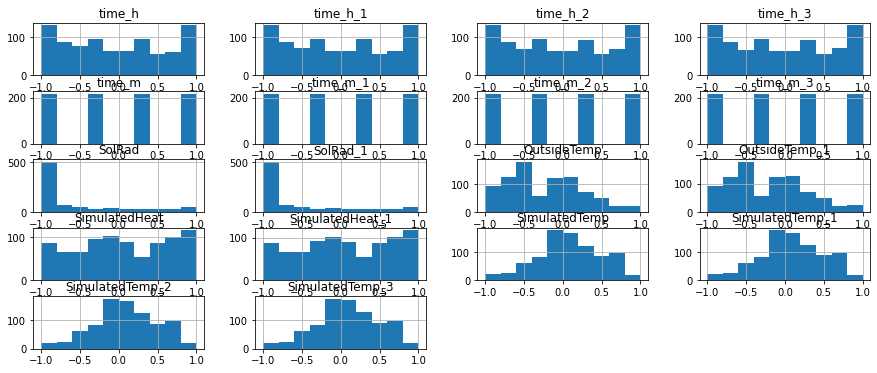

In [56]:
df_gpr_train.hist()

In [57]:
df_input_train = df_gpr_train.drop(columns = dict_cols['u'][1] + dict_cols['y'][1])
df_output_train = df_gpr_train[dict_cols['y'][1]]

In [58]:
df_input_train.head()

,time_h,time_h_1,time_h_2,time_h_3,time_m,time_m_1,time_m_2,time_m_3,SolRad,SolRad_1,OutsideTemp,OutsideTemp_1,SimulatedHeat_1,SimulatedTemp_1,SimulatedTemp_2,SimulatedTemp_3
timestamp,,,,,,,,,,,,,,,,
2017-06-01 20:45:00+02:00,0.739130,0.739130,0.739130,0.739130,1.000000,0.333333,-0.333333,-1.000000,-0.970807,-0.925970,0.058824,0.058824,0.438090,0.233535,0.214339,0.153839
2017-06-01 21:00:00+02:00,0.826087,0.739130,0.739130,0.739130,-1.000000,1.000000,0.333333,-0.333333,-0.980063,-0.970807,0.019608,0.058824,0.438090,0.248081,0.233535,0.214339
2017-06-01 21:15:00+02:00,0.826087,0.826087,0.739130,0.739130,-0.333333,-1.000000,1.000000,0.333333,-0.989906,-0.980063,-0.058824,0.019608,0.438090,0.216876,0.248081,0.233535
2017-06-01 21:30:00+02:00,0.826087,0.826087,0.826087,0.739130,0.333333,-0.333333,-1.000000,1.000000,-0.991909,-0.989906,-0.058824,-0.058824,-0.470064,0.062767,0.216876,0.248081
2017-06-01 21:45:00+02:00,0.826087,0.826087,0.826087,0.826087,1.000000,0.333333,-0.333333,-1.000000,-0.992483,-0.991909,-0.058824,-0.058824,-0.470064,0.091034,0.062767,0.216876


In [59]:
df_output_train.head()

,SimulatedTemp
timestamp,
2017-06-01 20:45:00+02:00,0.248081
2017-06-01 21:00:00+02:00,0.216876
2017-06-01 21:15:00+02:00,0.062767
2017-06-01 21:30:00+02:00,0.091034
2017-06-01 21:45:00+02:00,0.203306


In [60]:
np_input_train = df_input_train.to_numpy()
np_output_train = df_output_train.to_numpy().reshape(-1, 1)

In [61]:
np_input_train.shape

(864, 16)

### Define model and kernel

In [62]:
nb_dims = np_input_train.shape[1]
rational_dims = np.arange(0, (dict_cols['t'][0] + 1) * len(dict_cols['t'][1]), 1)
nb_rational_dims = len(rational_dims)
squared_dims = np.arange(nb_rational_dims, nb_dims, 1)
nb_squared_dims = len(squared_dims)

In [63]:
squared_l = [1] * nb_squared_dims
rational_l = [1] * nb_rational_dims

In [64]:
variance = tf.math.reduce_variance(np_input_train)

In [97]:
variance = 10

In [98]:
k0 = gpflow.kernels.SquaredExponential(lengthscales = squared_l, active_dims = squared_dims, variance = variance)
k1 = gpflow.kernels.Constant()
k2 = gpflow.kernels.RationalQuadratic(lengthscales = rational_l, active_dims = rational_dims, variance = variance)
k3 = gpflow.kernels.Periodic(k2)

In [99]:
k = (k0 + k1) * k2
print_summary(k)

name,class,transform,prior,trainable,shape,dtype,value
Product.kernels[0].kernels[0].variance,Parameter,Softplus,,True,(),float64,10.0
Product.kernels[0].kernels[0].lengthscales,Parameter,Softplus,,True,"(8,)",float64,"[1., 1., 1...."
Product.kernels[0].kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0
Product.kernels[1].variance,Parameter,Softplus,,True,(),float64,10.0
Product.kernels[1].lengthscales,Parameter,Softplus,,True,"(8,)",float64,"[1., 1., 1...."
Product.kernels[1].alpha,Parameter,Softplus,,True,(),float64,1.0


In [100]:
m = gpflow.models.GPR(
    data = (np_input_train, np_output_train), 
    kernel = k,
    mean_function = None
    )
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].kernels[0].variance,Parameter,Softplus,,True,(),float64,10.0
GPR.kernel.kernels[0].kernels[0].lengthscales,Parameter,Softplus,,True,"(8,)",float64,"[1., 1., 1...."
GPR.kernel.kernels[0].kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,10.0
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,"(8,)",float64,"[1., 1., 1...."
GPR.kernel.kernels[1].alpha,Parameter,Softplus,,True,(),float64,1.0
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


### Train model

In [101]:
opt = gpflow.optimizers.Scipy()

In [102]:
from datetime import datetime

In [103]:
start_time = datetime.now()
opt.minimize(m.training_loss, m.trainable_variables)
print(f"Finished fitting in {datetime.now() - start_time}")
print_summary(m)

Finished fitting in 0:00:16.041917


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].kernels[0].variance,Parameter,Softplus,,True,(),float64,680.0158754974991
GPR.kernel.kernels[0].kernels[0].lengthscales,Parameter,Softplus,,True,"(8,)",float64,"[3879.61410136, 3611.74772391, 2705.86685632..."
GPR.kernel.kernels[0].kernels[1].variance,Parameter,Softplus,,True,(),float64,0.0
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,2.5528463890805164
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,"(8,)",float64,"[4756.27621398, 4614.06336408, 4742.18906451..."
GPR.kernel.kernels[1].alpha,Parameter,Softplus,,True,(),float64,2859.355412460411
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0019562304623461906


### Evaluate performance on training data

In [104]:
nb_plts = len(dfs_gpr_train)

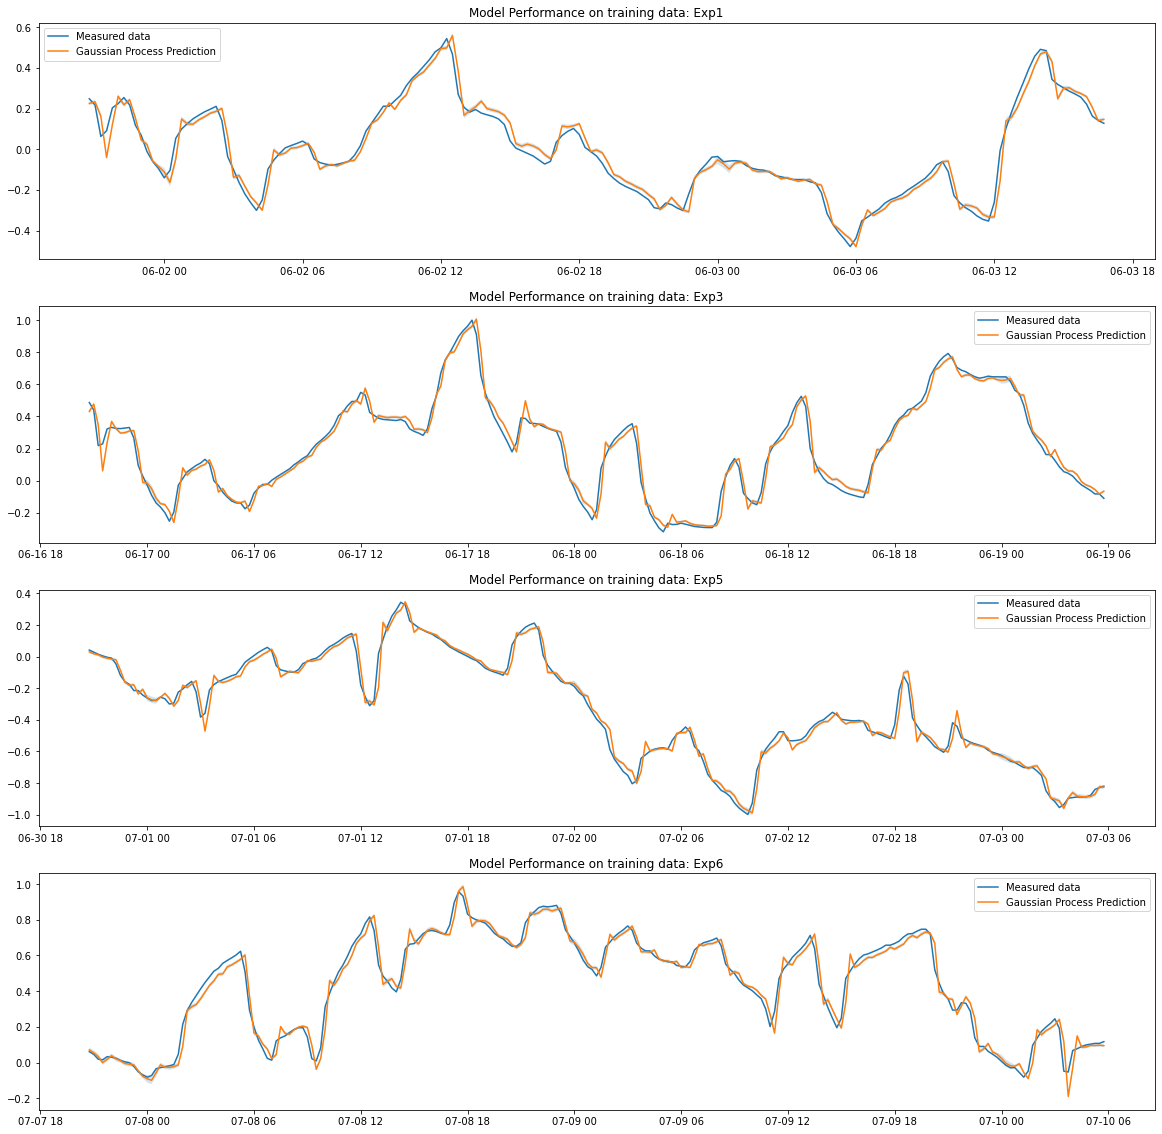

In [105]:
plt.figure(figsize = (20, 20))

for idx, df_iter in enumerate(dfs_gpr_train):
    plt.subplot(nb_plts, 1, idx + 1)
    df_input_iter = df_iter.drop(columns = dict_cols['y'][1] + dict_cols['u'][1])
    df_output_iter = df_iter[dict_cols['y'][1]]
    np_input_iter = df_input_iter.to_numpy()
    np_output_iter = df_output_iter.to_numpy().reshape(-1, 1)
    
    mean, var = m.predict_f(np_input_iter)
    
    plt.plot(df_iter.index, np_output_iter[:, :], label = 'Measured data')
    plt.plot(df_iter.index, mean[:, :], label = 'Gaussian Process Prediction')
    plt.fill_between(
        df_iter.index, 
        mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
        mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
        alpha = 0.2
    )
    plt.title(f"Model Performance on training data: {train_exps[idx]}")
    plt.legend()
plt.show()

## Evaluate performance on test data

In [95]:
dfs_gpr_test = []
for df_sc in dfs_test_sc:
    dfs_gpr_test.append(data_to_gpr(df_sc, dict_cols))

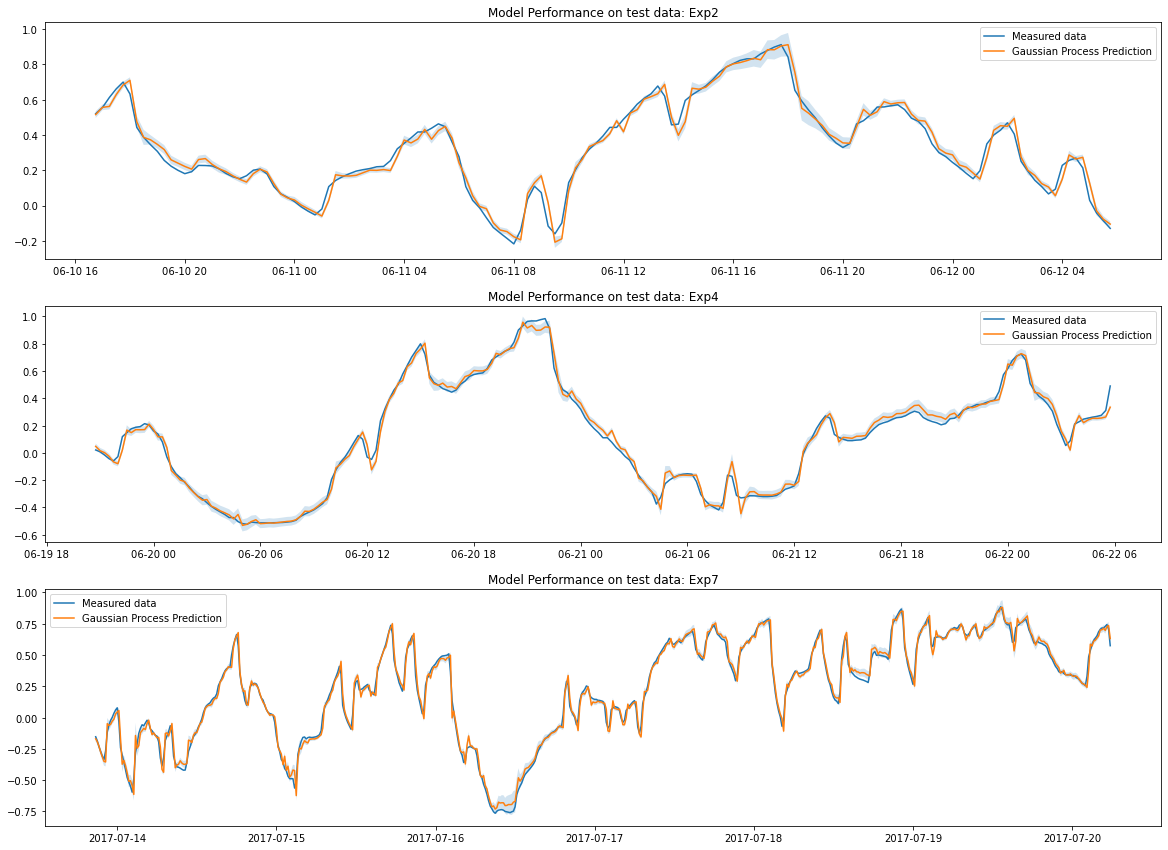

In [96]:
plt.figure(figsize = (20, 20))

for idx, df_iter in enumerate(dfs_gpr_test):
    plt.subplot(nb_plts, 1, idx + 1)
    df_input_iter = df_iter.drop(columns = dict_cols['y'][1] + dict_cols['u'][1])
    df_output_iter = df_iter[dict_cols['y'][1]]
    np_input_iter = df_input_iter.to_numpy()
    np_output_iter = df_output_iter.to_numpy().reshape(-1, 1)
    
    mean, var = m.predict_f(np_input_iter)
    
    plt.plot(df_iter.index, np_output_iter[:, :], label = 'Measured data')
    plt.plot(df_iter.index, mean[:, :], label = 'Gaussian Process Prediction')
    plt.fill_between(
        df_iter.index, 
        mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
        mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
        alpha = 0.2
    )
    plt.title(f"Model Performance on test data: {test_exps[idx]}")
    plt.legend()
plt.show()

In [72]:
pickle.dump(dfs_gpr_train, open(Path("dfs_gpr_train.pkl"), 'wb'))
pickle.dump(dfs_gpr_test, open(Path("dfs_gpr_test.pkl"), 'wb'))
pickle.dump(scaler, open(Path("scaler.pkl"), 'wb'))

In [73]:
np.linalg.cond(
    np_input_train[:100, :]
)

432.87418821478263

In [74]:
np.linalg.cond(
    k(np_input_train[:, :])
)

4.4999054032351606e+21

In [75]:
def simulate_carnot_gp(df_wdb, df, power_signal, m):
    
    df_local = df.copy()
    
    power = np.array([df_wdb['time'], power_signal]).T
    runtime = df_wdb['time'].iloc[-1]
    
    eng.workspace['power'] = matlab.double(power.tolist())
    eng.set_param('polydome', 'StopTime', str(runtime), nargout = 0)
    eng.workspace['result'] = eng.sim('polydome')
    df_simulation = carnot_to_series(eng, df.index[0])
    
    df_local.loc[:,'SimulatedTemp'] = df_simulation
    df_local.loc[:,'SimulatedHeat'] = power[:, 1]
    
    df_sc = get_scaled_df(df_local, w_list, u_list, y_list, scaler)
    df_gpr = data_to_gpr(df_sc)

    df_input = df_gpr.drop(columns = ['u', 'y'])
    df_output = df_gpr['y']
    
    np_input_test = df_input.to_numpy()
    #np_output_test = df_output.to_numpy().reshape(-1, 1)
    
    mean, var = m.predict_y(np_input_test)
        
    df_local.loc[3:, 'gpTemp'] = mean
    df_local.loc[3:, 'gpVar'] = var
    
    return df_local

In [76]:
#df_sim = simulate_carnot_gp(df_wdb, df, random_signal, m)
#df_sim.fillna(0, inplace = True)

### Export Gaussian Process Model

In [77]:
def export_gpr(path, m, w_scaler, u_scaler, y_scaler):
    m_params = gpflow.utilities.parameter_dict(m)
    pickle.dump(m_params, open(Path(path, 'gp_params.gpf'), 'wb'))
    pickle.dump(m.data, open(Path(path, 'gp_data.gpf'), 'wb'))
    pickle.dump(w_scaler, open(Path(path, 'w_scaler.pkl'), 'wb'))
    pickle.dump(u_scaler, open(Path(path, 'u_scaler.pkl'), 'wb'))
    pickle.dump(y_scaler, open(Path(path, 'y_scaler.pkl'), 'wb'))

In [78]:
export_path = Path(Path.cwd(), 'model')
export_path

PosixPath('/home/radu/Projects/Master-Project/Notebooks/model')

In [79]:
export_gpr(export_path, m, w_scaler, u_scaler, y_scaler)

NameError: name 'w_scaler' is not defined

In [ ]:
from scipy.io import savemat

In [ ]:
table_cols = df_gpr_train.columns.to_list()

In [ ]:
mdict = {
    'table_cols': table_cols,
    'gpr_train': dfs_gpr_train,
    'gpr_test': dfs_gpr_test
}

In [ ]:
savemat("test_mat.mat", mdict)

### Evaluate performance with new input and disturbances

In [ ]:
df_wdb, df = load_weather_data("Exp7")
len_signal = len(df_wdb)

In [ ]:
random_signal = get_random_signal(len_signal, a_range = (- COP_cooling * Pel_max, COP_heating * Pel_max), signal_type = 'analog')

In [ ]:
df_sim = simulate_carnot_gp(df_wdb, df, random_signal, m)

In [ ]:
plt.figure() 
plt.subplot(2,1,1)
plt.plot(df_sim.index, df_sim['SimulatedTemp'], label = 'Simulated Temperature')
plt.plot(df.index, df['OutsideTemp'], '-.', label = 'Outside Temperature')
plt.title('Temperatures')
plt.legend()
plt.subplot(2,1,2)
plt.plot(df_sim['SimulatedHeat'], drawstyle = 'steps', label = 'Heat Input')
plt.title('Heat Input')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize = (20, 5))
plt.plot(df_sim.index, df_sim['SimulatedTemp'], label = 'Measured data')
plt.plot(df_sim.index, df_sim['gpTemp'], label = 'Gaussian Process Prediction')
plt.fill_between(
    df_sim.index, 
    df_sim['gpTemp'] - 1.96 * np.sqrt(df_sim['gpVar']),
    df_sim['gpTemp'] + 1.96 * np.sqrt(df_sim['gpVar']),
    alpha = 0.2
)
plt.legend()
plt.title("Gaussian Process Performance on new random input data/ new weather data")
plt.show()

In [ ]:
### Simulate the System with constant Zero Input

In [ ]:
random_signal = get_random_signal(len_signal, a_range = [0,0], signal_type = 'analog')

In [ ]:
df_sim = simulate_carnot_gp(df_wdb, df, random_signal, m)

In [ ]:
df_sim

In [ ]:
plt.figure() 
plt.subplot(2,1,1)
plt.plot(df_sim.index, df_sim['SimulatedTemp'], label = 'Simulated Temperature')
plt.plot(df.index, df['OutsideTemp'], '-.', label = 'Outside Temperature')
plt.title('Temperatures')
plt.legend()
plt.subplot(2,1,2)
plt.plot(df_sim['SimulatedHeat'], drawstyle = 'steps', label = 'Heat Input')
plt.title('Heat Input')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize = (20, 5))
plt.plot(df_sim.index, df_sim['SimulatedTemp'], label = 'Measured data')
plt.plot(df_sim.index, df_sim['gpTemp'], label = 'Gaussian Process Prediction')
plt.fill_between(
    df_sim.index, 
    df_sim['gpTemp'] - 1.96 * np.sqrt(df_sim['gpVar']),
    df_sim['gpTemp'] + 1.96 * np.sqrt(df_sim['gpVar']),
    alpha = 0.2
)
plt.legend()
plt.title("Gaussian Process Performance on new weather data with constant zero input")
plt.show()

In [ ]:
### GP prediction N steps ahead

In [ ]:
df_sim

In [ ]:
df_sim[['OutsideTemp', 'SolRad']]

In [ ]:
df_sc = get_scaled_df(df_sim, w_scaler, u_scaler, y_scaler)
df_gpr = data_to_gpr(df_sc)

df_input = df_gpr.drop(columns = ['u', 'y'])
df_output = df_gpr['y']

In [ ]:
df_input = dfs_gpr_test[0].drop(columns = u_list + y_list)
df_output = dfs_gpr_test[0][y_list]

In [ ]:
N_pred = 11

In [ ]:
idx = 1

In [ ]:
df_iter = df_input.iloc[idx:(idx + N_pred)].copy()
df_iter

In [ ]:
for idxx in range(N_pred - 1):
    mean, var = m.predict_f(df_iter.iloc[idxx, :].to_numpy().reshape(1, -1))
    df_iter.iloc[idxx + 1, 7] = mean.numpy().flatten()
    df_iter.iloc[idxx + 1, 8] = df_iter.iloc[idxx, 7]

In [ ]:
df_iter

In [ ]:
data_to_gpr(dfs_train[0], lags_list, col_lists)

In [ ]:
y_list

In [ ]:
df_iter.index[0]

In [ ]:
df_iter

In [ ]:
u_lags

In [ ]:
mean_iter, var_iter = m.predict_f(df_iter.to_numpy())

In [ ]:
plt.figure()
plt.plot(df_iter.index, mean_iter.numpy(), 'o-', label = 'predicted', color = 'orange')
plt.plot(df_output.iloc[idx:idx + N_pred], 'o-', label = 'measured', color = 'darkblue')
plt.legend()

In [ ]:
nb_predictions = 10
N_pred = 8

In [ ]:
plt.figure()
plt.plot(df_output.iloc[:nb_predictions + N_pred], 'o-', label = 'measured', color = 'darkblue')

In [ ]:
plt.figure()

for idx in range(nb_predictions):
    df_iter = df_input.iloc[idx:(idx + N_pred)].copy()
    for idxx in range(N_pred - 1):
        mean, var = m.predict_f(df_iter.iloc[idxx, :].to_numpy().reshape(1, -1))
        df_iter.iloc[idxx + 1, 4] = mean.numpy().flatten()
        mean, var = m.predict_f(df_iter.iloc[idxx, :].to_numpy().reshape(1, -1))
        df_iter.iloc[idxx + 1, 7] = mean.numpy().flatten()
        df_iter.iloc[idxx + 1, 8] = df_iter.iloc[idxx, 7]
        
    mean_iter, var_iter = m.predict_y(df_iter.to_numpy())
    plt.plot(df_iter.index, mean_iter.numpy(), '.-', label = 'predicted', color = 'orange')
plt.plot(df_output.iloc[:nb_predictions + N_pred], 'o-', label = 'measured', color = 'darkblue')
plt.title(f"Prediction over {N_pred} steps")


In [ ]:
df_input[['SolRad', 'OutsideTemp']].plot()